## Imports

In [28]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_distribution
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

## Connect to ibm

In [ ]:
service = QiskitRuntimeService(token='THE TOKEN CODE',channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)

### The algorithm will be for 2 qubits.
### Choosing state 11 by applying cz gate to it to mark it
### X gates not needed here since cz will only affect 11 state

In [ ]:
# Create a quantum circuit with 2 qubits. It will be the oracle
oracle = QuantumCircuit(2, name='oracle')

# Apply a controlled-Z gate between qubit 0 and qubit 1
oracle.cz(0, 1)

# Draw the circuit diagram
oracle.draw()

q_0: ─■─
      │ 
q_1: ─■─

### Making circuit of 2 qubits
### Putting qubits into superposition with H and appending oracle to the circuit

In [ ]:
# Create a quantum circuit with 2 qubits and 2 classical bits
grover_circuit = QuantumCircuit(2, 2)

# Apply Hadamard gates to both qubits to create a superposition state
grover_circuit.h([0, 1])

# Append the previously defined oracle to the circuit
grover_circuit.append(oracle, [0, 1])

# Draw the circuit diagram
grover_circuit.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤0        ├
     ├───┤│  oracle │
q_1: ┤ H ├┤1        ├
     └───┘└─────────┘
c: 2/════════════════

### Creating a reflection about the mean of the amplitudes 
### By putting qubits into superposition with H, doing a phase flip with Z and reverting back to computational basis with H

In [ ]:
# Create a quantum circuit with 2 qubits 
reflection = QuantumCircuit(2, name='reflection')

# Apply Hadamard gates to both qubits
reflection.h([0, 1])

# Apply Pauli-Z gates to both qubits (phase flip)
reflection.z([0, 1])

# Apply a controlled-Z (CZ) gate between qubit 0 and qubit 1
reflection.cz(0, 1)

# Apply Hadamard gates again to complete the reflection operation
reflection.h([0, 1])

# Convert the circuit into a gate for use in larger circuit
reflection_gate = reflection.to_gate()

# Draw the circuit diagram
reflection.draw()

┌───┐┌───┐   ┌───┐
q_0: ┤ H ├┤ Z ├─■─┤ H ├
     ├───┤├───┤ │ ├───┤
q_1: ┤ H ├┤ Z ├─■─┤ H ├
     └───┘└───┘   └───┘

### This is the full circuit

In [ ]:
# Create a quantum circuit with 2 qubits and 2 classical bits for measurement
grover_circuit = QuantumCircuit(2, 2)

# Apply Hadamard gates to both qubits to create a superposition state
grover_circuit.h([0, 1])

# Append the previously defined oracle to the circuit
grover_circuit.append(oracle, [0, 1])

# Append the reflection (Grover diffusion operator) to the circuit
grover_circuit.append(reflection, [0, 1])

# Measure both qubits and store the results in the classical bits
grover_circuit.measure([0, 1], [0, 1])

# Draw the circuit diagram
grover_circuit.draw()

┌───┐┌─────────┐┌─────────────┐┌─┐   
q_0: ┤ H ├┤0        ├┤0            ├┤M├───
     ├───┤│  oracle ││  reflection │└╥┘┌─┐
q_1: ┤ H ├┤1        ├┤1            ├─╫─┤M├
     └───┘└─────────┘└─────────────┘ ║ └╥┘
c: 2/════════════════════════════════╩══╩═
                                     0  1

### Transpiling to optimize circuit for quantum machine

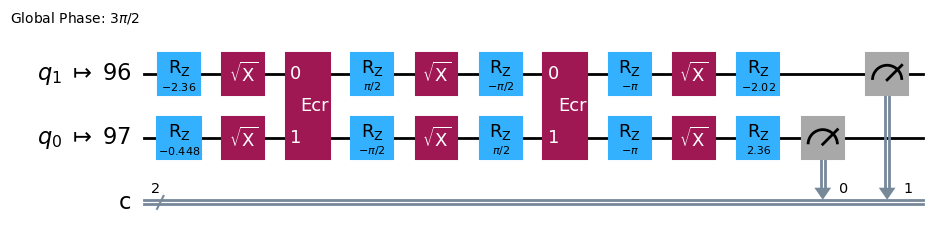

In [ ]:
# Get the target device's backend 
target = backend.target

# Generate a pass manager with the specified optimization level 
pm = generate_preset_pass_manager(target=target, optimization_level=3)

# Apply the pass manager to optimize the Grover circuit
circuit_isa = pm.run(grover_circuit)

# Draw the optimized circuit using the matplotlib style, showing the idle wires and using 'iqp' style for visuals
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

### Running the algorithm and measuring results
### after running once we get 11 state most of the time
### after running 100 times we get 11 state around 95% of the time

{'11': 95, '01': 3, '10': 2}


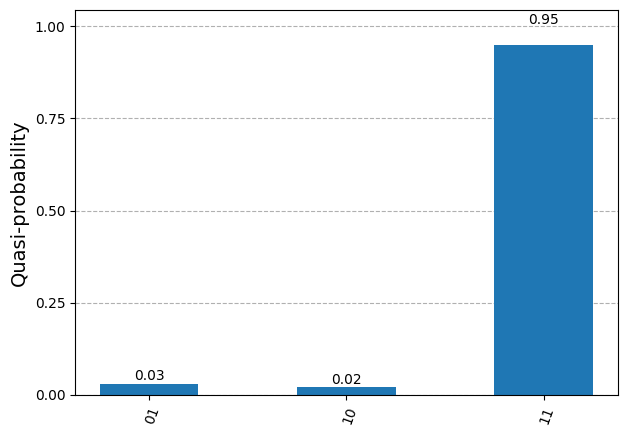

In [ ]:
# Create a sampler using the backend 
sampler = Sampler(mode=backend)

# Set the default number of repetitions for the experiment
sampler.options.default_shots = 100

# Run the optimized Grover circuit and retrieve the result
result = sampler.run([circuit_isa]).result()

# Extract the counts (measurement results) from the result object
dist = result[0].data.c.get_counts()

# Print the distribution of results
print(dist)

# Plot the distribution of the measurement results
plot_distribution(dist)